In [146]:
import os
import re
import csv
import json
import sys

import glob
import random
import pickle
import pprint
import logging
from datetime import datetime
from pathlib import Path
from decimal import Decimal, ROUND_HALF_UP

import torch
import pytorch_lightning as pl

import numpy as np
import pandas as pd

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from sklearn.preprocessing import LabelEncoder

import hydra
from omegaconf import DictConfig, OmegaConf

from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator, FixedFormatter, FixedLocator

import shap
import seaborn as sns
import xgboost as xgb

# Set output path

In [149]:
figures_dir = Path("./figures/")
current_date = datetime.now()
current_day = current_date.strftime('%Y-%m-%d') 
current_time = current_date.strftime('%H-%M-%S')

figures_dir = Path(figures_dir, current_day, current_time)
os.makedirs(figures_dir, exist_ok=True)

In [150]:
figures_dir

PosixPath('figures/2022-04-07/13-26-23')

In [151]:
color_list = [
    "#ff4b00",
    "#03af7a",
    "#4dc4ff",
    "#f6aa00",
    "#990099"
]

customPalette = sns.set_palette(sns.color_palette(color_list))

In [152]:
# os.environ['CUDA_VISIBLE_DEVICES'] = str(0)

seed = 42
random.seed(seed)
np.random.seed(seed)  
torch.manual_seed(seed)

torch.cuda.manual_seed(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

pl.seed_everything(seed)

Global seed set to 42


42

# Methods

In [153]:
def readSchema(path=""):
    if path:
        readFile = open(path, 'r')
    else:
        readFile = open('./data/schema.csv', 'r')

    reader = csv.reader(readFile)

    schemaDict = {}

    for row in reader:
        print(row)
        name = row[1]
        ruby = row[2]
        name_kana = row[0]
        ruby = re.sub("\n", " ", ruby)
        ruby = re.sub(": .+", "", ruby)
        
        schemaDict[name] = {
            "ruby": ruby,
            "ruby_kana": name_kana,
        }

        if row[3]:
            schemaDict[name]["ruby"] = schemaDict[name]["ruby"] + "*"
            
            valueList = re.split(',', row[3])
            itemList = re.split(',', row[5])

            schemaDict[name]["item"] = {}

            for index, value in enumerate(valueList):
                if value != '-':
                    value = int(value)

                schemaDict[name]["item"][value] = itemList[index]
        
        if row[4]:
            schemaDict[name]["ruby_kana"] = schemaDict[name]["ruby"] + "*"
            
            valueList = re.split(',', row[3])
            itemList = re.split(',', row[4])

            schemaDict[name]["item_kana"] = {}

            for index, value in enumerate(valueList):
                if value != '-':
                    value = int(value)

                schemaDict[name]["item_kana"][value] = itemList[index]

    return schemaDict

In [154]:
def readData(data_path, hyper_params: OmegaConf, fold_number: int):
    data_path = Path(data_path, str(fold_number))

    train_data_list = []
    train_labels_list = []

    val_data_list = []
    val_labels_list = []

    test_data_list = []
    test_labels_list = []

    data_unlabeled_list = []

    categorical_columns_list = []
    class_weights_list = []

    for fold_val_path in glob.glob(str(data_path) + "/[0-9]"):
        if hyper_params.is_used_raw_data:
            train_data = pd.read_csv(Path(fold_val_path, "train_data.csv") , index_col=0)
            val_data = pd.read_csv(Path(fold_val_path, "val_data.csv") , index_col=0)
            test_data = pd.read_csv(Path(fold_val_path, "test_data.csv") , index_col=0)
            data_unlabeled = pd.read_csv(Path(fold_val_path, "data_unlabeled.csv") , index_col=0)
            
        else:
            train_data = pd.read_csv(Path(fold_val_path, "train_data_std.csv") , index_col=0)
            val_data = pd.read_csv(Path(fold_val_path, "val_data_std.csv") , index_col=0)
            test_data = pd.read_csv(Path(fold_val_path, "test_data_std.csv") , index_col=0)
            data_unlabeled = pd.read_csv(Path(fold_val_path, "data_unlabeled_std.csv") , index_col=0)
        
        categorical_columns = pd.read_csv(Path(fold_val_path, "categorical_columns.csv"), index_col=0)

        train_labels = pd.read_csv(Path(fold_val_path, "train_labels.csv") , index_col=0)
        val_labels = pd.read_csv(Path(fold_val_path, "val_labels.csv") , index_col=0)
        test_labels = pd.read_csv(Path(fold_val_path, "test_labels.csv") , index_col=0)

        data_train_and_unlabeled = train_data.copy()
        data_train_and_unlabeled = data_train_and_unlabeled.append(data_unlabeled)

        data_all = data_train_and_unlabeled.copy()

        data_all = data_all.append(val_data)
        data_all = data_all.append(test_data)

        for column in train_data.columns.values:
            if column in categorical_columns.values.flatten().tolist():
                train_data = train_data.astype({column: int})
                test_data = test_data.astype({column: int})
                val_data = val_data.astype({column: int})
                data_all = data_all.astype({column: int})
                
                train_data[column] = train_data[column] - 1
                test_data[column] = test_data[column] - 1
                val_data[column] = val_data[column] - 1
                data_all[column] = data_all[column] - 1
                
                le = LabelEncoder()
                le.fit(data_all[column].unique())
                
                train_data[column] = le.transform(train_data[column])
                val_data[column] = le.transform(val_data[column])
                test_data[column] = le.transform(test_data[column])
                data_all[column] = le.transform(data_all[column].values)

        logging.info("class weights: " + str(class_weights))

        train_data_list.append(train_data)
        train_labels_list.append(train_labels)

        val_data_list.append(val_data)
        val_labels_list.append(val_labels)

        test_data_list.append(test_data)
        test_labels_list.append(test_labels)
        
        data_unlabeled_list.append(data_unlabeled)

        categorical_columns_list.append(categorical_columns)
    
    return_data_dict = {
        "train_data_list": train_data_list,
        "train_labels_list": train_labels_list,
        "val_data_list": val_data_list,
        "val_labels_list": val_labels_list,
        "test_data_list": test_data_list,
        "test_labels_list": test_labels_list,
        "data_unlabeled_list": data_unlabeled_list,
        "categorical_columns_list": categorical_columns_list,
    }
    
    return return_data_dict

In [155]:
def readConfigList(config_dir_path: str) -> list:
    config_list = []
    
    if config_dir_path[-1] != "/":
        config_dir_path += "/"
    
    for fold_test_yml_path in glob.glob(str(config_dir_path) + "/[0-9]/*.yml"):
        print(f"Path: {fold_test_yml_path}")

        with open(fold_test_yml_path, mode='r') as fp:
            config = OmegaConf.load(fp)
            config_list.append(config)
    
    return config_list

In [156]:
def readDataList(config_list):
    data_dict = {}

    for fold_number, config in enumerate(config_list):
        data_path = config.trainer.data_path
        hyper_params = config.trainer.hyper_params
        data_dict[fold_number] = readData(data_path, hyper_params, fold_number)
    
    return data_dict

In [158]:
def readModel(path: Path):
    model_path = Path(path, "model_xgboost.pickle")
    model = pickle.load(open(model_path, "rb"))
    return model

In [159]:
def readModelList(config_list: list):    
    model_dict = {}
    
    for config in config_list:
        test_path = Path(config.trainer.hyper_params.output_path, "test")
        fold_test_number = config.trainer.hyper_params.fold_number

        model_dict[fold_test_number] = {}

        for fold_val_number in range(0, 5):
            val_path = Path(test_path, f"Fold_{fold_val_number}")
            if val_path.exists():
                model_dict[fold_test_number][fold_val_number] = readModel(val_path)

            else:
                sys.exit()
    
    return model_dict

In [161]:
def readResult(path: Path):
    result_json_path = Path(path, "result.json")
    
    with open(result_json_path, "r") as open_file:
        result = json.load(open_file)
    
    return result

In [162]:
def readResultList(config_list: list):
    test_result_dict = {}
    
    for config in config_list:
        fold_test_number = config.trainer.hyper_params.fold_number
        test_path = Path(config.trainer.hyper_params.output_path, "test")
        test_result_dict[fold_test_number] = {}

        for fold_val_number in range(0, 5):
            val_path = Path(test_path, f"Fold_{fold_val_number}")

            if val_path.exists():
                test_result_dict[fold_test_number][fold_val_number] = readResult(val_path)
    
    return test_result_dict

In [163]:
def readScore(metrics_list:list, test_result_dict: dict):
    score_dict = {}

    for fold_test_number in sorted(test_result_dict):
        score_dict[fold_test_number] = {}
#         print(f"test number: {fold_test_number}")

        for metric in metrics_list:
            score_dict[fold_test_number][metric] = []
            for fold_val_number, result in test_result_dict[fold_test_number].items():
#                 print(f"  val number: {fold_val_number}")
#                 print(f"  {metric}: {result[metric]}")
                score_dict[fold_test_number][metric].append(result[metric])
    
    return score_dict

In [164]:
def calcAverageScore(metrics_list: list, score_dict: dict):
    score_avg_test_dict = {}
    
    for metric in metrics_list:
        score_avg_test_dict[metric] = []

        for fold_test_number, test_result in score_dict.items():
            avg_fold_score = np.mean(test_result[metric])
            print(f"{metric} ({fold_test_number}): {avg_fold_score}")
            score_avg_test_dict[metric].append(avg_fold_score)

    print()
    print(" *** Test average ***")
    for metric, score_list in score_avg_test_dict.items():
        df_score = pd.DataFrame(score_list, columns=[metric])
        avg_test_score = np.mean(score_list)
        
        df_describe = df_score.describe()

        mean = df_describe.loc['mean', :][metric]
        std = df_describe.loc['std', :][metric]
        
        mean_rounded = Decimal(str(mean)).quantize(Decimal('0.001'), rounding=ROUND_HALF_UP)
        std_rounded =  Decimal(str(std)).quantize(Decimal('0.001'), rounding=ROUND_HALF_UP)
        
        print(f"mean {metric}: {mean_rounded}")
        print(f"std {metric}: {std_rounded}")
        
        print()
    
    return score_avg_test_dict

In [165]:
def calcScore(model_dict, data_dict, metrics_list):
    test_score_list = {metric: [] for metric in metrics_list}

    for fold_test_number, val_model_dict in model_dict.items():
        val_score_dict = {metric: [] for metric in metrics_list}

        for fold_val_number, model in val_model_dict.items():
            y_true = data_dict[fold_test_number]["test_labels_list"][0].values
            y_pred = model.predict(data_dict[fold_test_number]["test_data_list"][fold_val_number].values)
            
            test_r2_score = r2_score(y_true, y_pred)
            test_rmse_score = np.sqrt(mean_squared_error(y_true, y_pred))
            test_mae_score = mean_absolute_error(y_true, y_pred)
            
            val_score_dict["test_r2_score"].append(test_r2_score)
            val_score_dict["test_rmse_score"].append(test_rmse_score)
            val_score_dict["test_mae_score"].append(test_mae_score)

        for metric in metrics_list:
            test_score_list[metric].append(np.mean(val_score_dict[metric]))

    for metric in metrics_list:
        df_score = pd.DataFrame(test_score_list, columns=[metric])
        print(df_score)

        df_describe = df_score.describe()

        mean = df_describe.loc['mean', :][metric]
        std = df_describe.loc['std', :][metric]

        mean_rounded = Decimal(str(mean)).quantize(Decimal('0.001'), rounding=ROUND_HALF_UP)
        std_rounded =  Decimal(str(std)).quantize(Decimal('0.001'), rounding=ROUND_HALF_UP)
        print(f"avg {metric}: {mean_rounded} $\pm$ {std_rounded}\n\n")

In [168]:
def calcShapValues(fold_test_number: int, model_dict: dict, data_dict: dict):    
    shap_values_dict = {}
    explainer_dict = {}

    for fold_val_number, model in model_dict[fold_test_number].items():
        print(f"val number: {fold_val_number}")
        
        shap_values_dict[fold_val_number] = {}

        explainer = shap.TreeExplainer(model=model,
                                       feature_perturbation="tree_path_dependent",
                                       model_output="raw")
        X_test = data_dict[fold_test_number]["test_data_list"][fold_val_number]

        shap_values = explainer.shap_values(X=X_test.values)
        
        shap.force_plot(base_value=explainer.expected_value, shap_values=shap_values, features=X_test.columns)
        shap_values = np.array(shap_values)
        
        shap_values_dict[fold_val_number] = shap_values
        explainer_dict[fold_val_number] = explainer
    
    return shap_values_dict, explainer_dict

In [169]:
def getHighImportanceColumns(fold_test_number: int, shap_values_dict: dict, data_dict: dict):
    high_importance_columns = []
    schemaDict = readSchema("./data/schema.csv")
    
    data = pd.DataFrame()
    
    for fold_val_number, values in shap_values_dict.items():
        columns_converted = [schemaDict[column]["ruby"] for column in data_dict[fold_test_number]["test_data_list"][fold_val_number].columns.tolist()]
        
        values = np.array(values)
        
        df_values = pd.DataFrame(
                    values, 
                    index=data_dict[fold_test_number]["test_data_list"][fold_val_number].index.tolist(), 
                    columns=columns_converted)
        

        data = data.append(df_values)
    
    data = data.abs()
    data = data.mean()
    abs_mean_shap_values = data.sort_values(ascending=False)
    
    df_abs_mean_shap_values = pd.DataFrame(data=abs_mean_shap_values.values,
                                           index=abs_mean_shap_values.index,
                                           columns=["value"])
    print(df_abs_mean_shap_values)
    
    return df_abs_mean_shap_values

In [170]:
def reshapeShapValuesToDataFrame(fold_test_number: int, shap_values_dict: dict, data_dict: dict, abs_mean_shap_values: pd.Series) -> pd.DataFrame:
    data_converted = pd.DataFrame()
    schemaDict = readSchema("./data/schema.csv")

    for fold_val_number, values in shap_values_dict.items():
        print(fold_val_number)
        columns_converted = [schemaDict[column]["ruby"] for column in data_dict[fold_test_number]["test_data_list"][fold_val_number].columns.tolist()]

        df_values = pd.DataFrame(
                    values, 
                    index=data_dict[fold_test_number]["test_data_list"][fold_val_number].index.tolist(), 
                    columns=columns_converted)

        for column in abs_mean_shap_values.index.tolist()[:20]:
            df_column_data = pd.DataFrame(
                index=data_dict[fold_test_number]["test_data_list"][fold_val_number].index.tolist(),
                data={
                    "Attribute": [f"{column}"] * len(values),
                    "SHAP Value": df_values[column].tolist(),
                    "Fold": [f"Valid Fold {fold_val_number + 1}"] * len(values),
                }
            )

            data_converted = data_converted.append(df_column_data)
    
    return data_converted

In [171]:
def makeModelDict(config_list, model_dict, data_dict, test_result_dict):    
    new_model_dict = {}
    
    for test_number, data_test_dict in data_dict.items():
        print(f"test number: {test_number}")
        new_model_dict[test_number] = {}
        
        config = config_list[test_number]
        
        for val_number in range(0, 5):
            X_train = data_test_dict["train_data_list"][val_number]
            y_train = data_test_dict["train_labels_list"][val_number]

            X_val = data_test_dict["val_data_list"][val_number]
            y_val = data_test_dict["val_labels_list"][val_number]

            X_test = data_test_dict["test_data_list"][val_number]
            y_test = data_test_dict["test_labels_list"][val_number]
            
            params = model_dict[test_number][val_number].get_params()
            
            model = xgb.XGBRegressor(
                objective=params["objective"],
                seed=params["seed"],
                n_estimators=params["n_estimators"],
                max_depth=params["max_depth"],
                learning_rate=params["learning_rate"],
                min_child_weight=params["min_child_weight"],
                gamma=params["gamma"],
                subsample=params["subsample"],
                colsample_bytree=params["colsample_bytree"],
                random_state=params["random_state"],
                tree_method=params["tree_method"], 
                gpu_id=params["gpu_id"]
            )
            
            if config.trainer.hyper_params.is_regression:


                model.fit(
                    X=X_train.values, 
                    y=y_train.values.flatten(),
                    eval_metric="rmse",
                    eval_set=[[X_val.values, y_val.values.flatten()]],
                    early_stopping_rounds=20,
                    verbose=False
                )
            
                y_pred = model.predict(X_test.values)
                test_r2_score = r2_score(y_test.values, y_pred)

                if test_r2_score != test_result_dict[test_number][val_number]["test_r2_score"]:
                    print(f"{test_number} / {val_number}")
                    print(test_r2_score)
                    print(test_result_dict[test_number][val_number]["test_r2_score"])
            
            else:
                raise
            
            new_model_dict[test_number][val_number] = model
            
            
    return new_model_dict

In [172]:
def makeShapValueDict(config_list, data_dict, new_model_dict):
    test_shap_values_dict = {}
    test_explainer_dict = {}

    for config in config_list:
        fold_test_number = config.trainer.hyper_params.fold_number
        shap_values_dict, explainer_dict = calcShapValues(fold_test_number, new_model_dict, data_dict)
        test_shap_values_dict[fold_test_number] = shap_values_dict
        test_explainer_dict[fold_test_number] = test_explainer_dict
    
    return test_shap_values_dict, test_explainer_dict

In [173]:
def makeShapDataFrame(data_dict, test_shap_values_dict, test_explainer_dict):
    schemaDict = readSchema("./data/schema.csv")
    df_shap = pd.DataFrame()

    for fold_test_number, val_shap_values_dict in test_shap_values_dict.items():
        print(fold_test_number)

        valid_shap_value_list = []
        columns_converted = [schemaDict[column]["ruby"] for column in data_dict[fold_test_number]["test_data_list"][0].columns.tolist()]

        for fold_val_number, shap_values in val_shap_values_dict.items():     
            valid_shap_value_list.append(shap_values)

        valid_shap_value_list = np.array(valid_shap_value_list)
        valid_shap_value_list = np.mean(valid_shap_value_list, axis=0)

        print(len(data_dict[fold_test_number]["test_data_list"][fold_val_number].index.tolist()))
        print(valid_shap_value_list.shape)

        df_shap_converted = pd.DataFrame(valid_shap_value_list, index=data_dict[fold_test_number]["test_data_list"][0].index.tolist(), columns=columns_converted)
        df_shap_converted["Fold"] = str(f"Test Fold {fold_test_number + 1}")
        df_shap = df_shap.append(df_shap_converted)
    
    # 
    df_shap_values = pd.DataFrame()
    schemaDict = readSchema("./data/schema.csv")

    for column in df_shap.loc[:, df_shap.columns != "Fold"].abs().mean().sort_values(ascending=False).index[0:20]:
        if column == "Fold":
            continue

        df_column_data = pd.DataFrame(
            index=df_shap.index.tolist(),
            data={
                "Attribute": [f"{column}"] * len(df_shap.index.tolist()),
                "SHAP Value": df_shap[column].tolist(),
                "Fold": df_shap["Fold"].tolist(),
            }
        )

        df_shap_values = df_shap_values.append(df_column_data)
    
    shap_abs_values = df_shap.loc[:, df_shap.columns != "Fold"].abs().mean().sort_values(ascending=False)[0:20]
    df_shap_abs_values = pd.DataFrame({"Attribute": shap_abs_values.index,"SHAP Value": shap_abs_values})

    return df_shap, df_shap_values, df_shap_abs_values

In [174]:
def makeFeatureImportanceDataFrame(data_dict, new_model_dict):
    df_total = pd.DataFrame()

    for fold_test_number, val_model_dict in new_model_dict.items():
        df_val_mean = pd.DataFrame()

        for fold_val_number, model in val_model_dict.items():
            df_values = pd.DataFrame(
                            model.feature_importances_, 
                            index=data_dict[fold_test_number]["test_data_list"][fold_val_number].columns.tolist(), 
                            columns=[f"Fold{fold_val_number}"])

            df_val_mean = df_val_mean.append(df_values.T)

        df_test_mean =  pd.DataFrame(
            df_val_mean.mean(),
            columns=[f"Fold {fold_test_number}"]
        )

        df_total = df_total.append(df_test_mean.T)
    
    df_mean = df_total.mean().sort_values(ascending=False)
    
    return df_mean

## Make ranking data

In [185]:
def makeRankingInYearsDataFrame(config_path_dict: list, data_year_dict: dict):
    temp_columns_list = []

    for year, condig_dir_path in sorted(config_path_dict.items(), key=lambda x:x[0]):
        df_temp_shap = data_year_dict[condig_dir_path]["df_shap"]

        temp_shap_abs_values = df_temp_shap.loc[:, df_temp_shap.columns != "Fold"].abs().mean().sort_values(ascending=False)
        df_temp_shap_abs_values = pd.DataFrame({"Attribute": temp_shap_abs_values.index,"SHAP Value": temp_shap_abs_values})

        temp_columns_list.extend(temp_shap_abs_values[0:20].index.tolist())

    temp_columns_list = list(set(temp_columns_list))
    
    columns = ["Attribute", "Year", "Rank"]

    df_ranking = pd.DataFrame(columns=columns)

    for year, condig_dir_path in sorted(config_path_dict.items(), key=lambda x:x[0]):
        year = int(re.sub("\D+", "", year))
        df_temp_shap = data_year_dict[condig_dir_path]["df_shap"]

        temp_shap_abs_values = df_temp_shap.loc[:, df_temp_shap.columns != "Fold"].abs().mean().sort_values(ascending=False)
        df_temp_shap_abs_values = pd.DataFrame({"Attribute": temp_shap_abs_values.index, "SHAP Value": temp_shap_abs_values})

        rank = 1

        for attribute, row in df_temp_shap_abs_values.iterrows():
            value = row["SHAP Value"]

            if attribute in temp_columns_list:            
                df_ranking_attribute = pd.DataFrame([[attribute, year, rank]], columns=columns)
                df_ranking = df_ranking.append(df_ranking_attribute)

            rank += 1
    
    df_ranking["Year"] = df_ranking["Year"].astype(int)
    df_ranking["Rank"] = df_ranking["Rank"].astype(int)

    return df_ranking

In [186]:
def makeSHAPandTruePredValueDataFrame(condition: str,
                                      config_dir_dict: dict,
                                      target_dict: dict,
                                      is_merged=True):
    
    schemaDict = readSchema("./data/schema.csv")

    years = ["1年後", "2年後", "3年後", "4年後"]

    df_years = pd.DataFrame()

    columns = target_dict[config_dir_dict[condition][years[0]]]["data_dict"][0]["test_data_list"][0].columns

    for num, attribute_id in enumerate(columns):
        attribute_name = schemaDict[attribute_id]["ruby"]
        print(f"{attribute_name} {num + 1}/{len(columns)}")
        
        for year in years:
            print(f"-->{year}")

            df_shap_values = target_dict[config_dir_dict[condition][year]]["df_shap"].copy()
            df_shap_each_attribute = df_shap_values[attribute_name].copy()
            df_shap_each_attribute = pd.DataFrame(df_shap_each_attribute)
            df_shap_each_attribute = df_shap_each_attribute.rename(columns={attribute_name: 'SHAP value'})
            df_shap_each_attribute["Attribute"] = attribute_name

#             print(df_shap_each_attribute)

            data_dict = target_dict[config_dir_dict[condition][year]]["data_dict"]
            model_dict = target_dict[config_dir_dict[condition][year]]["model_dict"]

            df_merged_attribute = pd.DataFrame()

            X_participants_list = []
            y_participants_list = []
            y_pred_list = []

            for fold_test_number in range(0, 5):        
                X_participants = data_dict[fold_test_number]["test_data_list"][0].copy()
                y_participants = data_dict[fold_test_number]["test_labels_list"][0].copy()

                val_list = []

                for fold_val_number in range(0, 5):
                    model = model_dict[fold_test_number][fold_val_number]
                    y_pred = model.predict(X_participants.values)
                    y_pred = pd.DataFrame(y_pred, index=X_participants.index, columns=["y_pred"])

                    val_list.append(y_pred)

                X_participants_list.append(X_participants)
                y_participants_list.append(y_participants)
                y_pred_list.append(val_list)

                X_participant_test = X_participants_list[fold_test_number]
                y_participant_test = y_participants_list[fold_test_number]

                for y_pred_val_list in y_pred_list:
                    if is_merged:
                        df_y_pred_mean = pd.DataFrame(index=y_pred_val_list[0].index)

                        for idx, df_y_pred_val in enumerate(y_pred_val_list):
                            df_y_pred_val = pd.DataFrame(df_y_pred_val.values, index=df_y_pred_val.index, columns=[f"Fold {idx + 1}"])
                            df_y_pred_mean = pd.merge(df_y_pred_mean, df_y_pred_val, left_index=True, right_index=True).copy()

                        df_y_pred_mean = pd.DataFrame(df_y_pred_mean.mean(axis='columns'), index=df_y_pred_mean.index, columns=["y_pred"]).copy()

                        df_temp_shap = pd.merge(df_shap_each_attribute, df_y_pred_mean, left_index=True, right_index=True).copy()
                        df_temp_shap = pd.merge(df_temp_shap, y_participant_test, left_index=True, right_index=True).copy()
                        df_temp_shap = df_temp_shap.rename(columns={'label': 'y_true'})

                        df_temp_shap = pd.merge(df_temp_shap, X_participant_test[attribute_id], left_index=True, right_index=True).copy()
                        df_temp_shap = df_temp_shap.rename(columns={attribute_id: 'Input value'})

                        df_merged_attribute = df_merged_attribute.append(df_temp_shap)                

                    else:    
                        for df_y_pred_val in y_pred_val_list:
                            df_temp_shap = pd.merge(df_shap_each_attribute, df_y_pred_val, left_index=True, right_index=True).copy()

                            df_temp_shap = pd.merge(df_temp_shap, y_participant_test, left_index=True, right_index=True).copy()
                            df_temp_shap = df_temp_shap.rename(columns={'label': 'y_true'})

                            df_temp_shap = pd.merge(df_temp_shap, X_participant_test[attribute_id], left_index=True, right_index=True).copy()
                            df_temp_shap = df_temp_shap.rename(columns={attribute_id: 'Input value'})

                            df_merged_attribute = df_merged_attribute.append(df_temp_shap)

            df_merged_attribute["Time interval"] = int(year[0])
            df_years = df_years.append(df_merged_attribute.copy())
            
    return df_years.copy()

## Load Data

In [188]:
def loadData(path_to_output_dict: dict, config_dir_path: str):
    config_list = readConfigList(config_dir_path)

    if config_list[0].trainer.hyper_params.is_regression:
        metrics_list = [
            "test_r2_score",
            "test_rmse_score",
            "test_mae_score"
        ]

    else:
        raise
    
    data_dict = readDataList(config_list)
    model_dict = readModelList(config_list)
    test_result_dict = readResultList(config_list)
    
    for fold_test_number, val_model_dict in model_dict.items():
        print(f"Test Fold {fold_test_number}:")
        pprint.pprint(val_model_dict[0].get_xgb_params(), compact=True)
        print()
    
    score_dict = readScore(metrics_list, test_result_dict)
    score_avg_test_dict = calcAverageScore(metrics_list, score_dict)
    calcScore(model_dict, data_dict, metrics_list)

    new_model_dict = makeModelDict(config_list, model_dict, data_dict, test_result_dict)
    calcScore(new_model_dict, data_dict, metrics_list)
    
    df_feature_importance_mean = makeFeatureImportanceDataFrame(data_dict, new_model_dict)
    schemaDict = readSchema("./data/schema.csv")

    for rank, element in enumerate(df_feature_importance_mean.items()):
        print(f"rank {rank + 1}")
        print(schemaDict[element[0]]["ruby"], element[1], element[0])
        print()
    
    return {
        "config_list": config_list,
        "data_dict": data_dict,
        "model_dict": model_dict,
        "test_result_dict": test_result_dict,
        "score_dict": score_dict,
        "score_avg_test_dict": score_avg_test_dict,
        "new_model_dict": new_model_dict,
        "df_feature_importance_mean": df_feature_importance_mean
    }

In [189]:
def makeSHAPandStatDataFrame(path_to_output_dict: dict, config_dir_path: str, experiment_result_dict: dict, target_dict: dict, target: str):
    config_list = experiment_result_dict["config_list"]
    data_dict = experiment_result_dict["data_dict"]
    new_model_dict = experiment_result_dict["new_model_dict"]

    test_shap_values_dict, test_explainer_dict = makeShapValueDict(config_list, data_dict, new_model_dict)
    df_shap, df_shap_values, df_shap_abs_values = makeShapDataFrame(data_dict, test_shap_values_dict, test_explainer_dict)
    
    experiment_result_dict["test_shap_values_dict"] = test_shap_values_dict
    experiment_result_dict["test_explainer_dict"] = test_explainer_dict
    experiment_result_dict["df_shap"] = df_shap
    experiment_result_dict["df_shap_values"] = df_shap_values
    experiment_result_dict["df_shap_abs_values"] = df_shap_abs_values

    target_dict[config_dir_path] = experiment_result_dict
    
    return target_dict, experiment_result_dict

## Draw ranking

In [98]:
def drawRankingYearsChange(path_to_output_dict: dict, config_dir_path: str, df_ranking: pd.DataFrame, fig_size=(8, 32)):
    output_path = path_to_output_dict[config_dir_path].parents[0]
    output_path = Path(figures_dir, output_path)
    os.makedirs(output_path, exist_ok=True)
    
    combination_list = str(path_to_output_dict[config_dir_path].parents[0]).split("/")
    combination_list[1] = re.sub("_", " ", combination_list[1])
    
    color_list = [
        "#ff4b00",
        "#03af7a",
        "#4dc4ff",
        "#f6aa00",
        "#990099"
    ] * 10
    
    markers = ["o", "^", "s", "h", "*", "D", "v"]
    marker_list = []
    
    for marker in markers:
        temp_list = [marker] * 5
        marker_list.extend(temp_list)
    
    color_list = color_list[0:df_ranking["Attribute"].unique().shape[0]]
    marker_list = marker_list[0:len(color_list)]
    size_list = [300] * (len(color_list) * 4)
    
    marker_attribute_list = []
    
    column_change_dict = {
        "Hemoglobin A1c": "HbA1c",
        "Fasting blood sugar": "FBS",
        "Status of Diabetes mellitus*": "Status of diabetes mellitus*",
        "Body mass index": "BMI",
        "High-density lipoprotein cholesterol": "HDL cholesterol",
        "Low-density lipoprotein cholesterol": "LDL cholesterol"
    }
    
    for idx, marker in enumerate(marker_list):
        if marker == "*":
            df_years = df_ranking.loc[df_ranking["Year"] == 1]
            attribute = df_years.iloc[idx]["Attribute"]
            marker_attribute_list.append(attribute)
    
    for attribute in marker_attribute_list:
        index_count = 0
        
        for year in range(1, 5):
            df_years = df_ranking.loc[df_ranking["Year"] == year]
            attribute_list = df_years["Attribute"].tolist()
            attribute_index = attribute_list.index(attribute)
            
            size_list[attribute_index + index_count] = 900
            
            index_count += len(df_years.index)
    
    sns.set_style("ticks")
    
    plt.figure(figsize=fig_size)
    plt.rcParams['pdf.fonttype'] = 'truetype'
    plt.rcParams["font.size"] = 30
    
    ax_line = sns.lineplot(data=df_ranking,
                      x="Year",
                      y="Rank",
                      hue="Attribute",
                      linewidth=1.5,
                      style="Attribute",
                      dashes=False,
                      legend=False,
                      palette=color_list,
                )
    
    ax_plot = sns.scatterplot(data=df_ranking,
                         x="Year",
                         y="Rank",
                         hue="Attribute",
                         s=size_list,
                         legend=False,
                         style='Attribute',
                         palette=color_list,
                         markers=marker_list
    )
    
    
    plt.ylim(-1, max(df_ranking["Rank"].max() + 1, 49))
#     plt.tick_params(width = 2, length = 10)

    ax_line.set(yticklabels=[])
    ax_line.set(ylabel=None)
    ax_line.set(yticks=[])
    
    ax_plot.set(yticklabels=[])
    ax_plot.set(ylabel=None)
    ax_plot.set(yticks=[])

    ax_plot.set(xlabel="Time interval (year)")
    
    ax_plot.set_title(" / ".join(combination_list))
    
    ax_line.xaxis.set_major_locator(MultipleLocator(1))
#     ax_line.yaxis.set_major_locator(MultipleLocator(1))
    
    ax_plot.xaxis.set_major_locator(MultipleLocator(1))
#     ax_plot.yaxis.set_major_locator(MultipleLocator(1))
    
    y_ax_list = df_ranking[df_ranking["Year"] == 1]["Rank"].to_list()

    y_ax_attribute_list = df_ranking[df_ranking["Year"] == 1]["Attribute"].to_list()

    for n, a_name in enumerate(y_ax_attribute_list):
        if a_name in column_change_dict:
            a_name = column_change_dict[a_name]
        
        y_ax_attribute_list[n] = f"{y_ax_list[n]}: {a_name}"

    yax1 = ax_plot.secondary_yaxis("left")
    yax1.yaxis.set_major_locator(FixedLocator(y_ax_list))
    yax1.yaxis.set_major_formatter(FixedFormatter(y_ax_attribute_list))
    
    y_ax_list = df_ranking[df_ranking["Year"] == 4]["Rank"].to_list()
    y_ax_attribute_list = df_ranking[df_ranking["Year"] == 4]["Attribute"].to_list()

    for n, a_name in enumerate(y_ax_attribute_list):
        if a_name in column_change_dict:
            a_name = column_change_dict[a_name]
            
        y_ax_attribute_list[n] = f"{y_ax_list[n]}: {a_name}"

    yax2 = ax_plot.secondary_yaxis("right")
    yax2.yaxis.set_major_locator(FixedLocator(y_ax_list))
    yax2.yaxis.set_major_formatter(FixedFormatter(y_ax_attribute_list))

    ax_line.invert_yaxis()
    
    plt.savefig(Path(output_path, "fig_shap_ranking.pdf"),
            format="pdf", 
            bbox_inches='tight',
            dpi=300, 
            pad_inches=0.0)

## Draw scatter plot

In [190]:
def makeScatterPlotSHAPValueAndInputValue(path_to_output_dict: dict, config_dir_path: str, df_years: pd.DataFrame, attribute: str):
    print(attribute)
    plt.rcParams["font.size"] = 30
    fig, axes = plt.subplots(2, 2, figsize=(20, 20), constrained_layout=True, sharey=True)
#     fig = plt.figure()
    
    df_one_interval = df_years[(df_years["Attribute"] == attribute) & (df_years["Time interval"] == 1)]
    df_two_interval = df_years[(df_years["Attribute"] == attribute) & (df_years["Time interval"] == 2)]
    df_three_interval = df_years[(df_years["Attribute"] == attribute) & (df_years["Time interval"] == 3)]
    df_four_interval = df_years[(df_years["Attribute"] == attribute) & (df_years["Time interval"] == 4)]
    
    shap_values_list = []
    shap_values_list.extend(df_one_interval["SHAP value"].values.tolist())
    shap_values_list.extend(df_two_interval["SHAP value"].values.tolist())
    shap_values_list.extend(df_three_interval["SHAP value"].values.tolist())
    shap_values_list.extend(df_four_interval["SHAP value"].values.tolist())
    
    max_shap_value = max(shap_values_list)
    min_shap_value = min(shap_values_list)
    
    y_pred_list = []
    y_pred_list.extend(df_one_interval["y_pred"].values.tolist())
    y_pred_list.extend(df_two_interval["y_pred"].values.tolist())
    y_pred_list.extend(df_three_interval["y_pred"].values.tolist())
    y_pred_list.extend(df_four_interval["y_pred"].values.tolist())
    
    max_pred_value = max(y_pred_list)
    min_pred_value = min(y_pred_list)
    
    output_path = path_to_output_dict[config_dir_path].parents[0]
    output_attribute_name = re.sub("\s", "_", attribute.lower())
    output_path = Path(figures_dir, output_path, "shap_plot_attributes", re.sub("\*", "", output_attribute_name))
    
    target_condition = re.sub("_", " ", str(path_to_output_dict[config_dir_path].parents[0])) 
    target_condition = re.split("/", target_condition)
    
#     ax = fig.add_subplot(111)
    
#     ax.spines['top'].set_color('none')
#     ax.spines['bottom'].set_color('none')
#     ax.spines['left'].set_color('none')
#     ax.spines['right'].set_color('none')
#     ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

#     fontsize = 16
    
    ax_one = axes[0, 0]
    ax_one.set_ylim(min_shap_value, max_shap_value)
    ax_one.set_title("One-year interval", fontsize=30)
#     ax_one.set_xlabel(attribute)
#     ax_one.set_ylabel("SHAP value", fontsize=30)
    ax_one.tick_params(width=1, length = 10)
    
    points_one = ax_one.scatter(x=df_one_interval["Input value"], 
                         y=df_one_interval["SHAP value"],
                         c=df_one_interval["y_pred"], 
                         s=10,
                         cmap="Spectral_r",
                         vmin=min_pred_value,
                         vmax=max_pred_value)
    
#     plt.colorbar(points_one)

    
    # ax_two = fig.add_subplot(2, 2, 2)
    ax_two = axes[0, 1]
    ax_two.set_title("Two-year interval", fontsize=30)
    ax_two.set_ylim(min_shap_value, max_shap_value)
    
#     ax_two.set_xlabel(attribute)
    ax_two.tick_params(width=1, length = 10)
    
    points_two = ax_two.scatter(x=df_two_interval["Input value"], 
                                y=df_two_interval["SHAP value"],
                                c=df_two_interval["y_pred"], 
                                s=10,
                                cmap="Spectral_r",
                                vmin=min_pred_value,
                                vmax=max_pred_value)
    
#     color_bar = plt.colorbar(points_two, label=f"Predicted {target_condition[0]}")
    
#     plt.colorbar(points_two)
    
    ax_three = axes[1, 0]
    ax_three.set_title("Three-year interval", fontsize=30)
    ax_three.set_ylim(min_shap_value, max_shap_value)
    
#     ax_three.set_xlabel(attribute, fontsize=30)
#     ax_three.set_ylabel("SHAP value", fontsize=30)

    ax_three.tick_params(width=1, length = 10)
    
    points_three = ax_three.scatter(x=df_three_interval["Input value"], 
                                y=df_three_interval["SHAP value"],
                                c=df_three_interval["y_pred"], 
                                s=10,
                                cmap="Spectral_r",
                                vmin=min_pred_value,
                                vmax=max_pred_value)
    
    ax_four = axes[1, 1]
    ax_four.set_title("Four-year interval", fontsize=30)
    ax_four.set_ylim(min_shap_value, max_shap_value)
#     ax_four.set_xlabel(attribute, fontsize=30)
    ax_four.tick_params(width=1, length = 10)
    
    points_four = ax_four.scatter(x=df_four_interval["Input value"], 
                                y=df_four_interval["SHAP value"],
                                c=df_four_interval["y_pred"], 
                                s=10,
                                cmap="Spectral_r",
                                vmin=min_pred_value,
                                vmax=max_pred_value)
    
    fig.supxlabel(attribute.capitalize())
    fig.supylabel("SHAP value", fontsize=30)
    
    os.makedirs(output_path, exist_ok=True)
    
    plt.savefig(Path(output_path, "fig_shap_and_input_value_plot_without_colorbar.pdf"),
                format="pdf", 
                bbox_inches='tight',
                dpi=300, 
                pad_inches=0.0)
    
    
    target_condition_name = target_condition[0]
    
    if target_condition_name == "Creatinine":
        target_condition_name = "creatinine"
    
    fig.colorbar(points_four, ax=axes[:, 1], label=f"Predicted {target_condition_name}")
    
    plt.savefig(Path(output_path, "fig_shap_and_input_value_plot.pdf"),
                format="pdf", 
                bbox_inches='tight',
                dpi=300, 
                pad_inches=0.0)
    
    plt.show()

In [45]:
path_to_output_dict = {}

# HbA1c

In [46]:
config_dir_dict_hba1c = {
    "関連指標あり": {
        "4年後": "./configs/XGBoost/.../is_used_raw_data_True",
        "3年後": "./configs/XGBoost/.../is_used_raw_data_True",
        "2年後": "./configs/XGBoost/.../is_used_raw_data_True",
        "1年後": "./configs/XGBoost/.../is_used_raw_data_True",
    },
    "関連指標なし": {
        "4年後": "./configs/XGBoost/.../is_used_raw_data_True",
        "3年後": "./configs/XGBoost/.../is_used_raw_data_True",
        "2年後": "./configs/XGBoost/.../is_used_raw_data_True",
        "1年後": "./configs/XGBoost/.../is_used_raw_data_True",
    }
}

In [ ]:
for key, dir_dict in config_dir_dict_hba1c.items():
    if key == "関連指標あり":
        key = "included"
    
    else:
        key = "not_included"
        
    year_intervals = {
        "1": "One-year",
        "2": "Two-year",
        "3": "Three-year",
        "4": "Four-year"
    }
    
    for year, dir_path in dir_dict.items():
        print(year, dir_path)
        year = re.sub("年後", "", year)
        year_str = f"{year_intervals[year]}_interval"
        
        path_to_output_dict[dir_path] = Path("HbA1c", key, year_str)

In [48]:
hba1c_dict = {}
for key, path_dict in config_dir_dict_hba1c.items():
    for interval, config_dir_path in path_dict.items():
        experiment_result_dict = loadData(path_to_output_dict, config_dir_path)
        hba1c_dict, experiment_result_dict = makeSHAPandStatDataFrame(path_to_output_dict, config_dir_path=config_dir_path, 
                                                              experiment_result_dict=experiment_result_dict,
                                                              target_dict=hba1c_dict,
                                                              target="HbA1c")

In [ ]:
# output_path = Path(figures_dir, "calculated_result")
# os.makedirs(output_path, exist_ok=True)

# with open(Path(output_path, "hba1c_dict.pickle"), mode='wb') as f:
#     pickle.dump(hba1c_dict, f)

In [ ]:
# open_file = open("./hba1c_dict.pickle", mode="rb")
# hba1c_dict =  pickle.load(open_file)

In [51]:
for key, dir_dict in config_dir_dict_hba1c.items():
    if key == "関連指標あり":
        key = "included"
    
    else:
        key = "not_included"
        
    for year, dir_path in dir_dict.items():
        print(key, year)
        score_dict = hba1c_dict[dir_path]["score_dict"]
        
        metrics_list = [
            "test_r2_score",
            "test_rmse_score",
            "test_mae_score"
        ]
        
        score_avg_test_dict = calcAverageScore(metrics_list, score_dict)

included 4年後
test_r2_score (0): 0.6119147592631605
test_r2_score (1): 0.6335027064246463
test_r2_score (2): 0.6851561496023375
test_r2_score (3): 0.5228211178142721
test_r2_score (4): 0.5610812792581419
test_rmse_score (0): 0.24323693386572381
test_rmse_score (1): 0.21400676485648348
test_rmse_score (2): 0.19924283130179404
test_rmse_score (3): 0.2656251159603775
test_rmse_score (4): 0.24851726020954282
test_mae_score (0): 0.15896239612119417
test_mae_score (1): 0.14637168025294095
test_mae_score (2): 0.15354896761846878
test_mae_score (3): 0.16100283764778298
test_mae_score (4): 0.17487291606605476

 *** Test average ***
mean test_r2_score: 0.603
std test_r2_score: 0.063

mean test_rmse_score: 0.234
std test_rmse_score: 0.027

mean test_mae_score: 0.159
std test_mae_score: 0.011

included 3年後
test_r2_score (0): 0.5903608713915471
test_r2_score (1): 0.6452489199065894
test_r2_score (2): 0.5864111339076782
test_r2_score (3): 0.6262320921499442
test_r2_score (4): 0.6237379227920237
test_

## Included

### Ranking

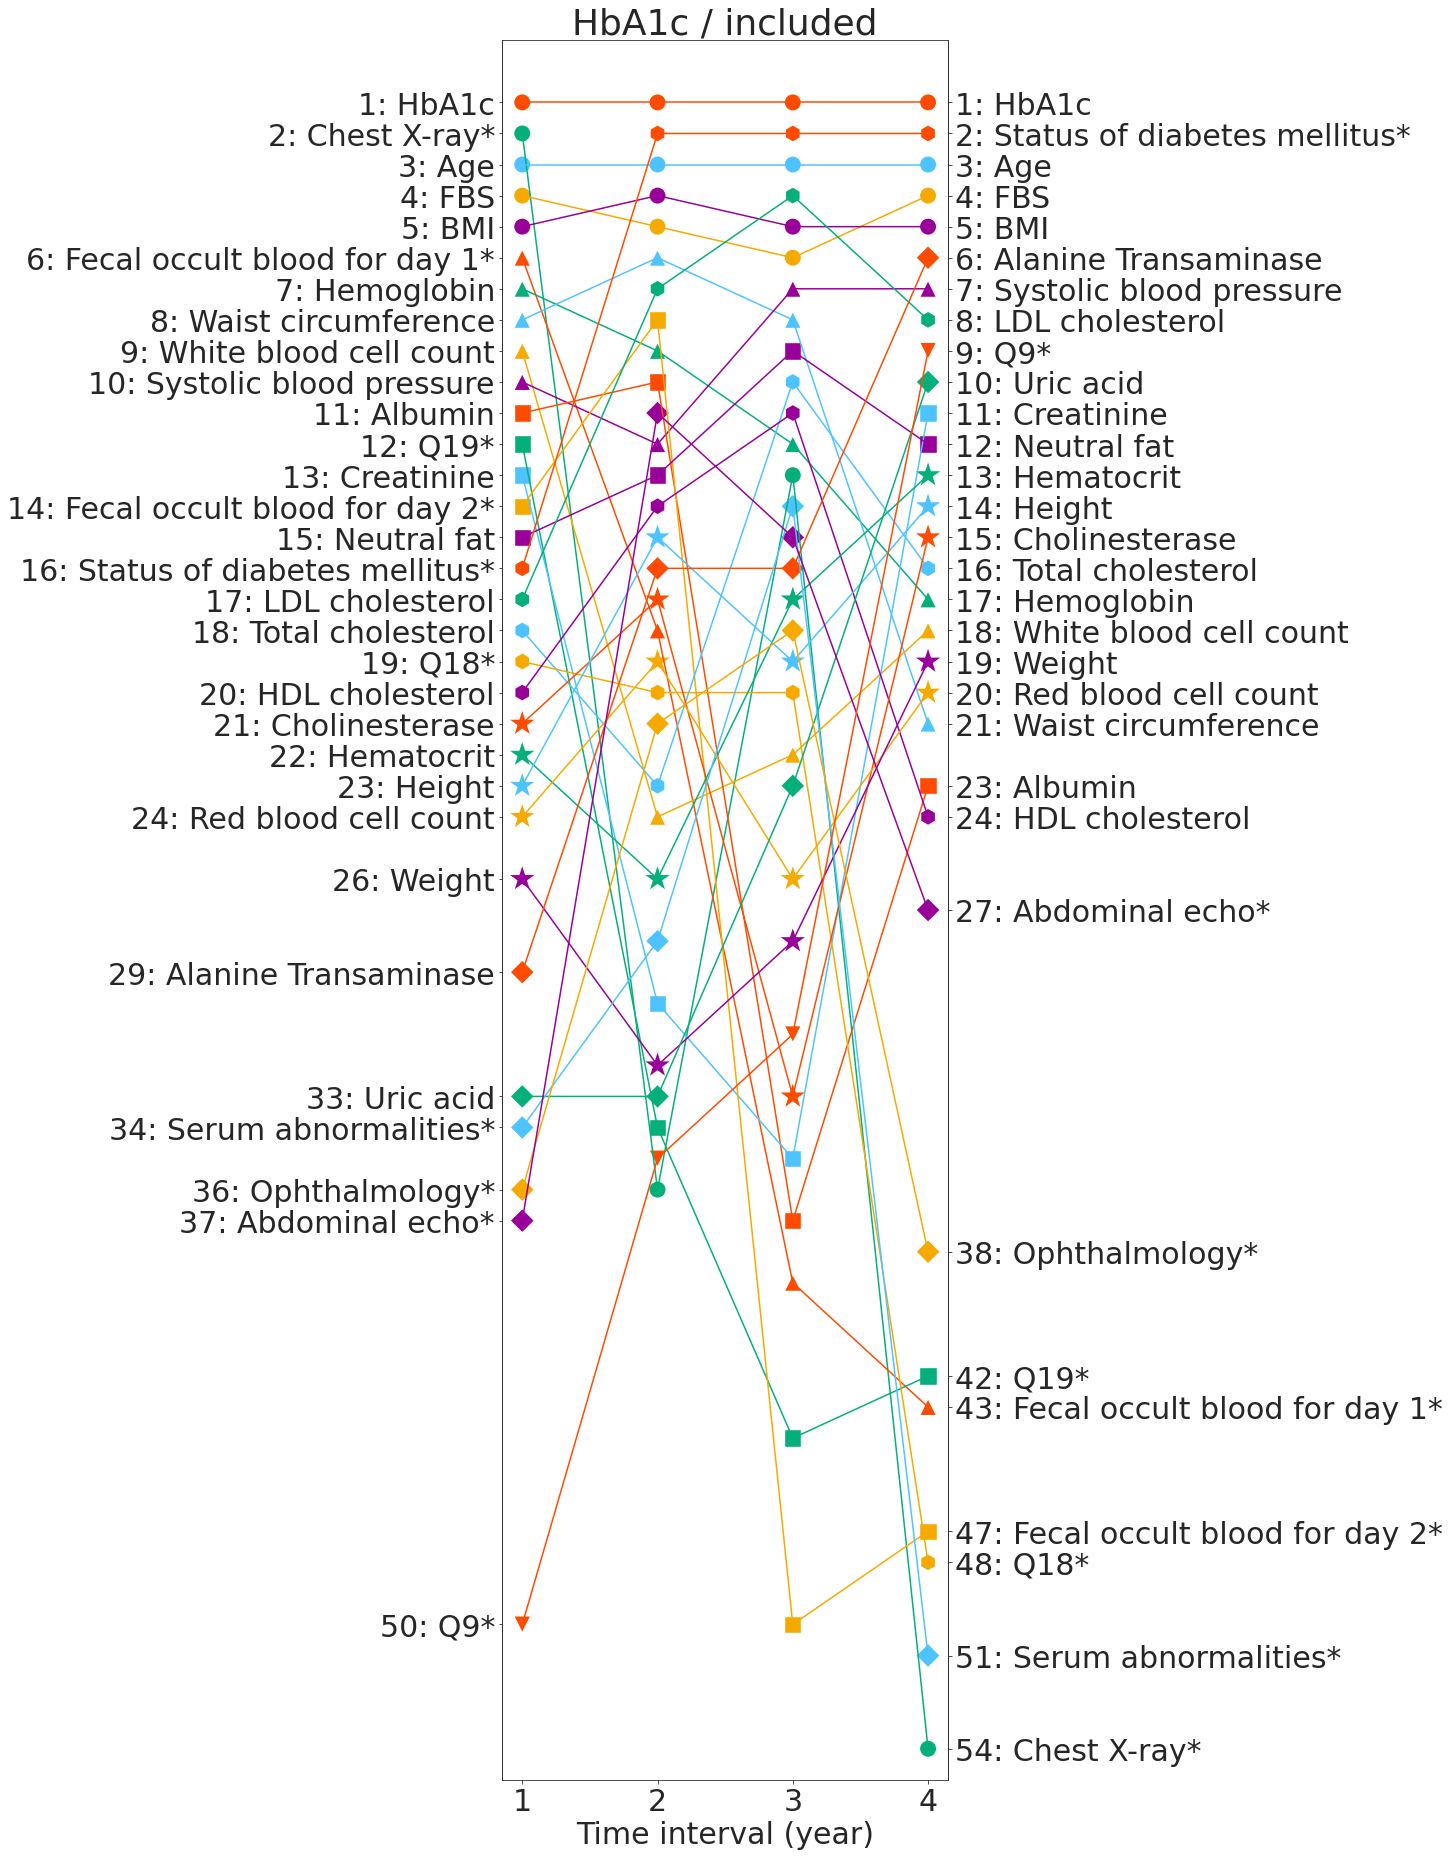

In [99]:
df_ranking = makeRankingInYearsDataFrame(config_dir_dict_hba1c["関連指標あり"], hba1c_dict)
drawRankingYearsChange(path_to_output_dict, list(config_dir_dict_hba1c["関連指標あり"].values())[0], df_ranking)

### Scatter plot

In [ ]:
df_years_hba1c_included = makeSHAPandTruePredValueDataFrame(condition="関連指標あり", config_dir_dict=config_dir_dict_hba1c, target_dict=hba1c_dict, is_merged=True)

In [ ]:
for column in df_years_hba1c_included["Attribute"].unique():
    makeScatterPlotSHAPValueAndInputValue(path_to_output_dict, list(config_dir_dict_hba1c["関連指標あり"].values())[0], df_years_hba1c_included, column)

## not included

### Ranking

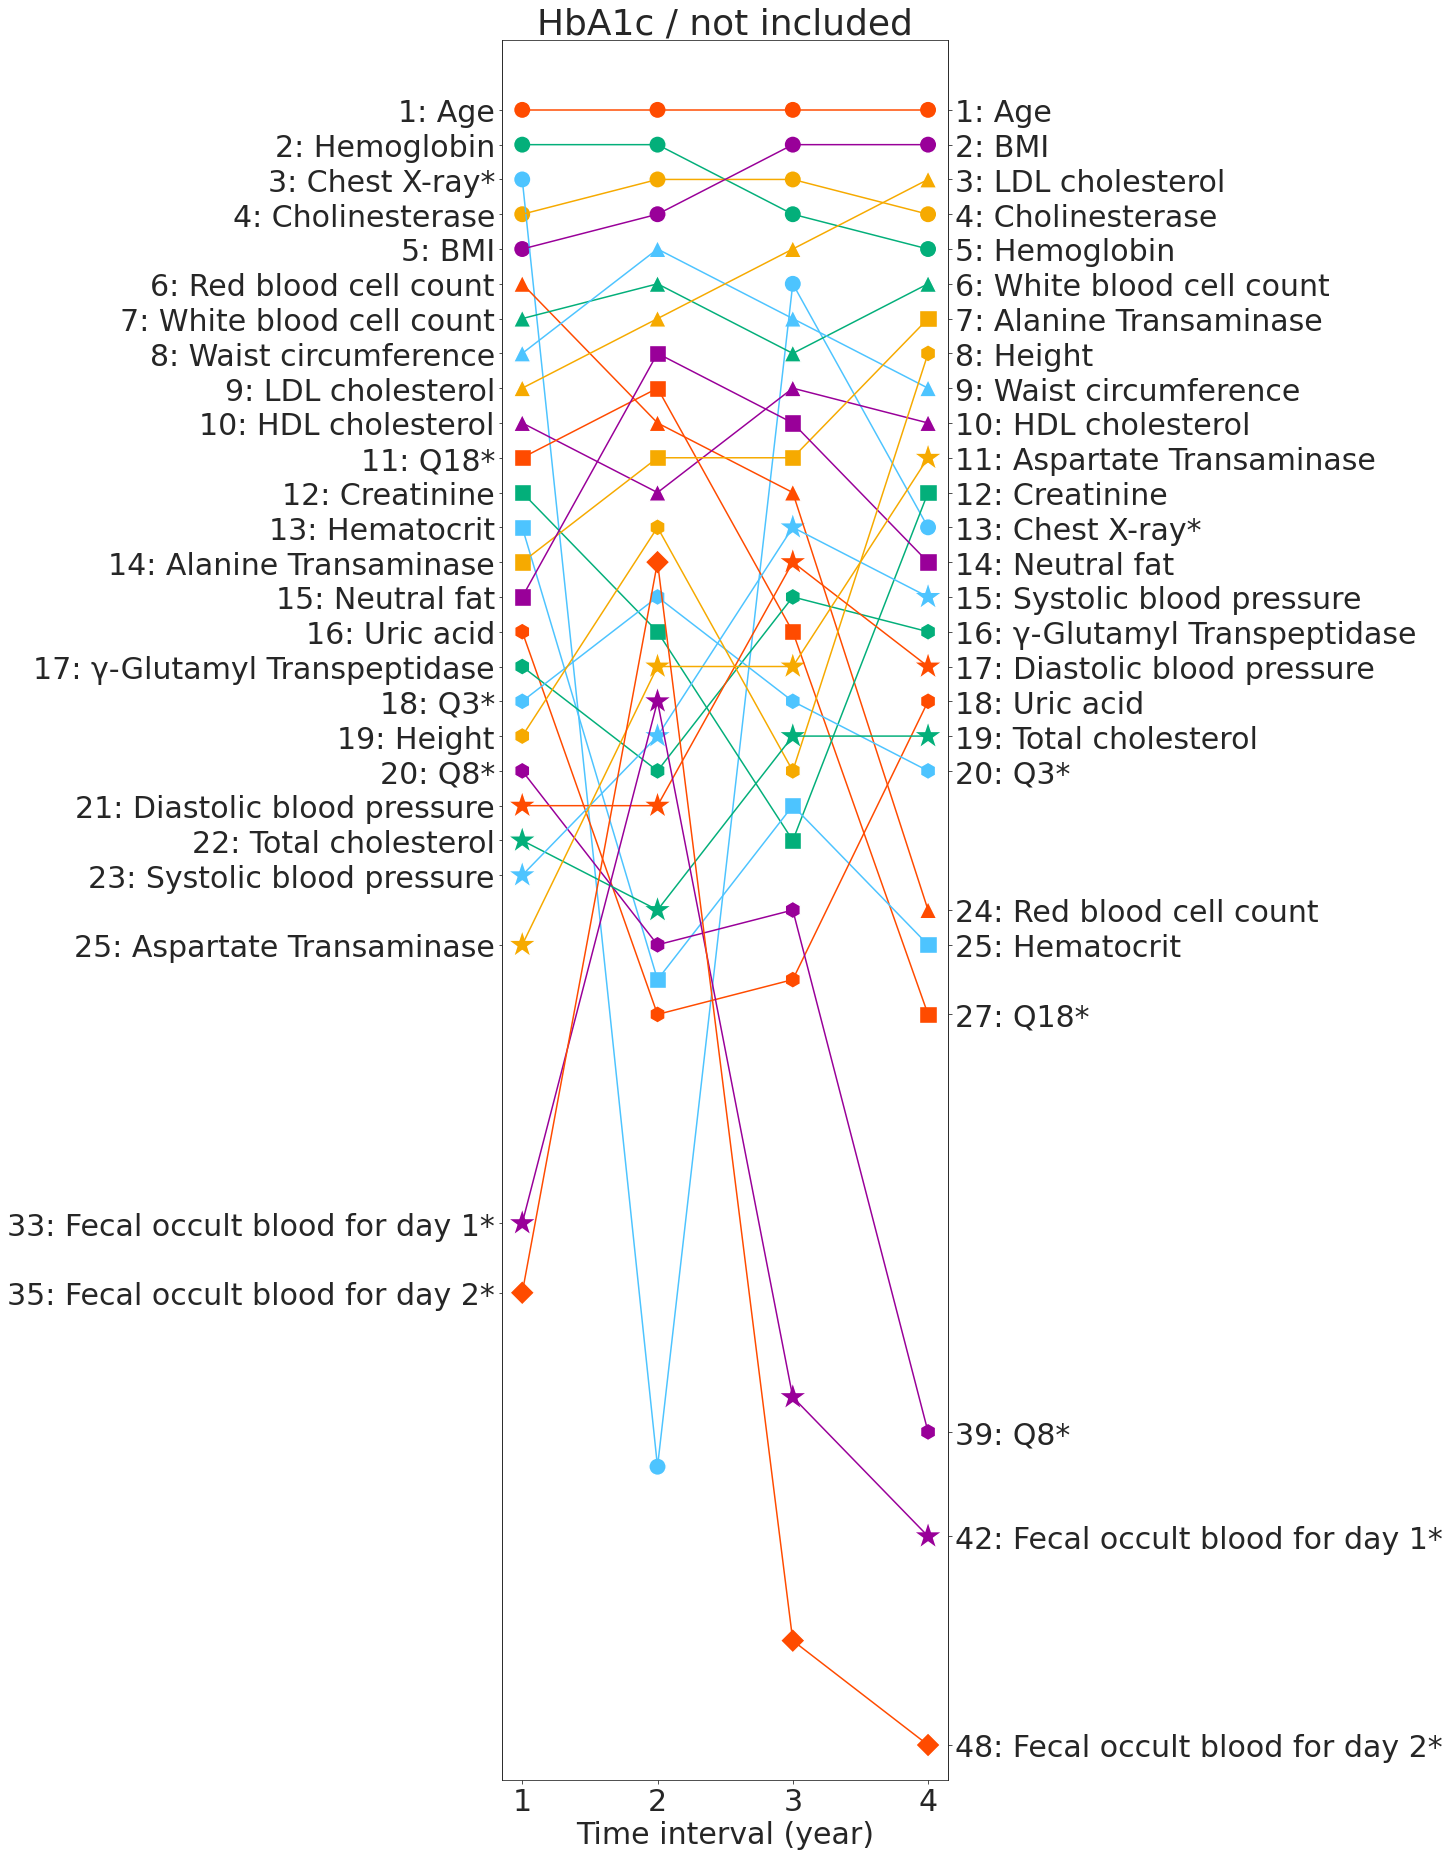

In [100]:
df_ranking = makeRankingInYearsDataFrame(config_dir_dict_hba1c["関連指標なし"], hba1c_dict)
drawRankingYearsChange(path_to_output_dict, list(config_dir_dict_hba1c["関連指標なし"].values())[0], df_ranking)

### Scatter plot

In [ ]:
df_years_hba1c_not_included = makeSHAPandTruePredValueDataFrame(condition="関連指標なし", config_dir_dict=config_dir_dict_hba1c, target_dict=hba1c_dict, is_merged=True)

In [ ]:
for column in df_years_hba1c_not_included["Attribute"].unique():
    makeScatterPlotSHAPValueAndInputValue(path_to_output_dict, list(config_dir_dict_hba1c["関連指標なし"].values())[0], df_years_hba1c_not_included, column)

# Creatinine

In [191]:
config_dir_dict_creatinine = {
    "関連指標あり": {
        "4年後": "./configs/XGBoost/.../is_used_raw_data_True",
        "3年後": "./configs/XGBoost/.../is_used_raw_data_True",
        "2年後": "./configs/XGBoost/.../is_used_raw_data_True",
        "1年後": "./configs/XGBoost/.../is_used_raw_data_True",
    },
    "関連指標なし": {
        "4年後": "./configs/XGBoost/.../is_used_raw_data_True",
        "3年後": "./configs/XGBoost/.../is_used_raw_data_True",
        "2年後": "./configs/XGBoost/.../is_used_raw_data_True",
        "1年後": "./configs/XGBoost/.../is_used_raw_data_True",
    }
    
}

In [ ]:
for key, dir_dict in config_dir_dict_creatinine.items():
    if key == "関連指標あり":
        key = "included"
    
    else:
        key = "not_included"

    year_intervals = {
        "1": "One-year",
        "2": "Two-year",
        "3": "Three-year",
        "4": "Four-year"
    }
    
    for year, dir_path in dir_dict.items():
        print(year, dir_path)
        year = re.sub("年後", "", year)
        year_str = f"{year_intervals[year]}_interval"
        
        path_to_output_dict[dir_path] = Path("Creatinine", key, year_str)

In [193]:
creatinine_dict = {}
for key, path_dict in config_dir_dict_creatinine.items():
    for interval, config_dir_path in path_dict.items():
        
        experiment_result_dict = loadData(path_to_output_dict, config_dir_path)
        creatinine_dict, experiment_result_dict = makeSHAPandStatDataFrame(path_to_output_dict, config_dir_path=config_dir_path, 
                                                              experiment_result_dict=experiment_result_dict,
                                                              target_dict=creatinine_dict,
                                                              target="creatinine")

In [194]:
# output_path = Path(figures_dir, "calculated_result")
# os.makedirs(output_path, exist_ok=True)

# with open(Path(output_path, "creatinine_dict.pickle"), mode='wb') as f:
#     pickle.dump(creatinine_dict, f)

In [195]:
# open_file = open("calculated_result/creatinine_dict.pickle", mode="rb")
# creatinine_dict =  pickle.load(open_file)

In [196]:
for key, dir_dict in config_dir_dict_creatinine.items():
    if key == "関連指標あり":
        key = "included"
    
    else:
        key = "not_included"
        
    for year, dir_path in dir_dict.items():
        print(key, year)
        score_dict = creatinine_dict[dir_path]["score_dict"]
        
        metrics_list = [
            "test_r2_score",
            "test_rmse_score",
            "test_mae_score"
        ]
        
        score_avg_test_dict = calcAverageScore(metrics_list, score_dict)

included 4年後
test_r2_score (0): 0.8374267154088132
test_r2_score (1): 0.8458187906868911
test_r2_score (2): 0.8318377302010773
test_r2_score (3): 0.8339565905468784
test_r2_score (4): 0.8388526251696311
test_rmse_score (0): 0.06283658149598298
test_rmse_score (1): 0.06171932827799083
test_rmse_score (2): 0.06551437806754934
test_rmse_score (3): 0.06840634893492101
test_rmse_score (4): 0.06498048108288057
test_mae_score (0): 0.04724004523422339
test_mae_score (1): 0.046655580570011075
test_mae_score (2): 0.04862028020716793
test_mae_score (3): 0.04885320762677485
test_mae_score (4): 0.04927200023384837

 *** Test average ***
mean test_r2_score: 0.838
std test_r2_score: 0.005

mean test_rmse_score: 0.065
std test_rmse_score: 0.003

mean test_mae_score: 0.048
std test_mae_score: 0.001

included 3年後
test_r2_score (0): 0.8298480223811373
test_r2_score (1): 0.8534601139010164
test_r2_score (2): 0.8550252428658034
test_r2_score (3): 0.8599942468077604
test_r2_score (4): 0.8391703012500853
tes

## Included

### Ranking

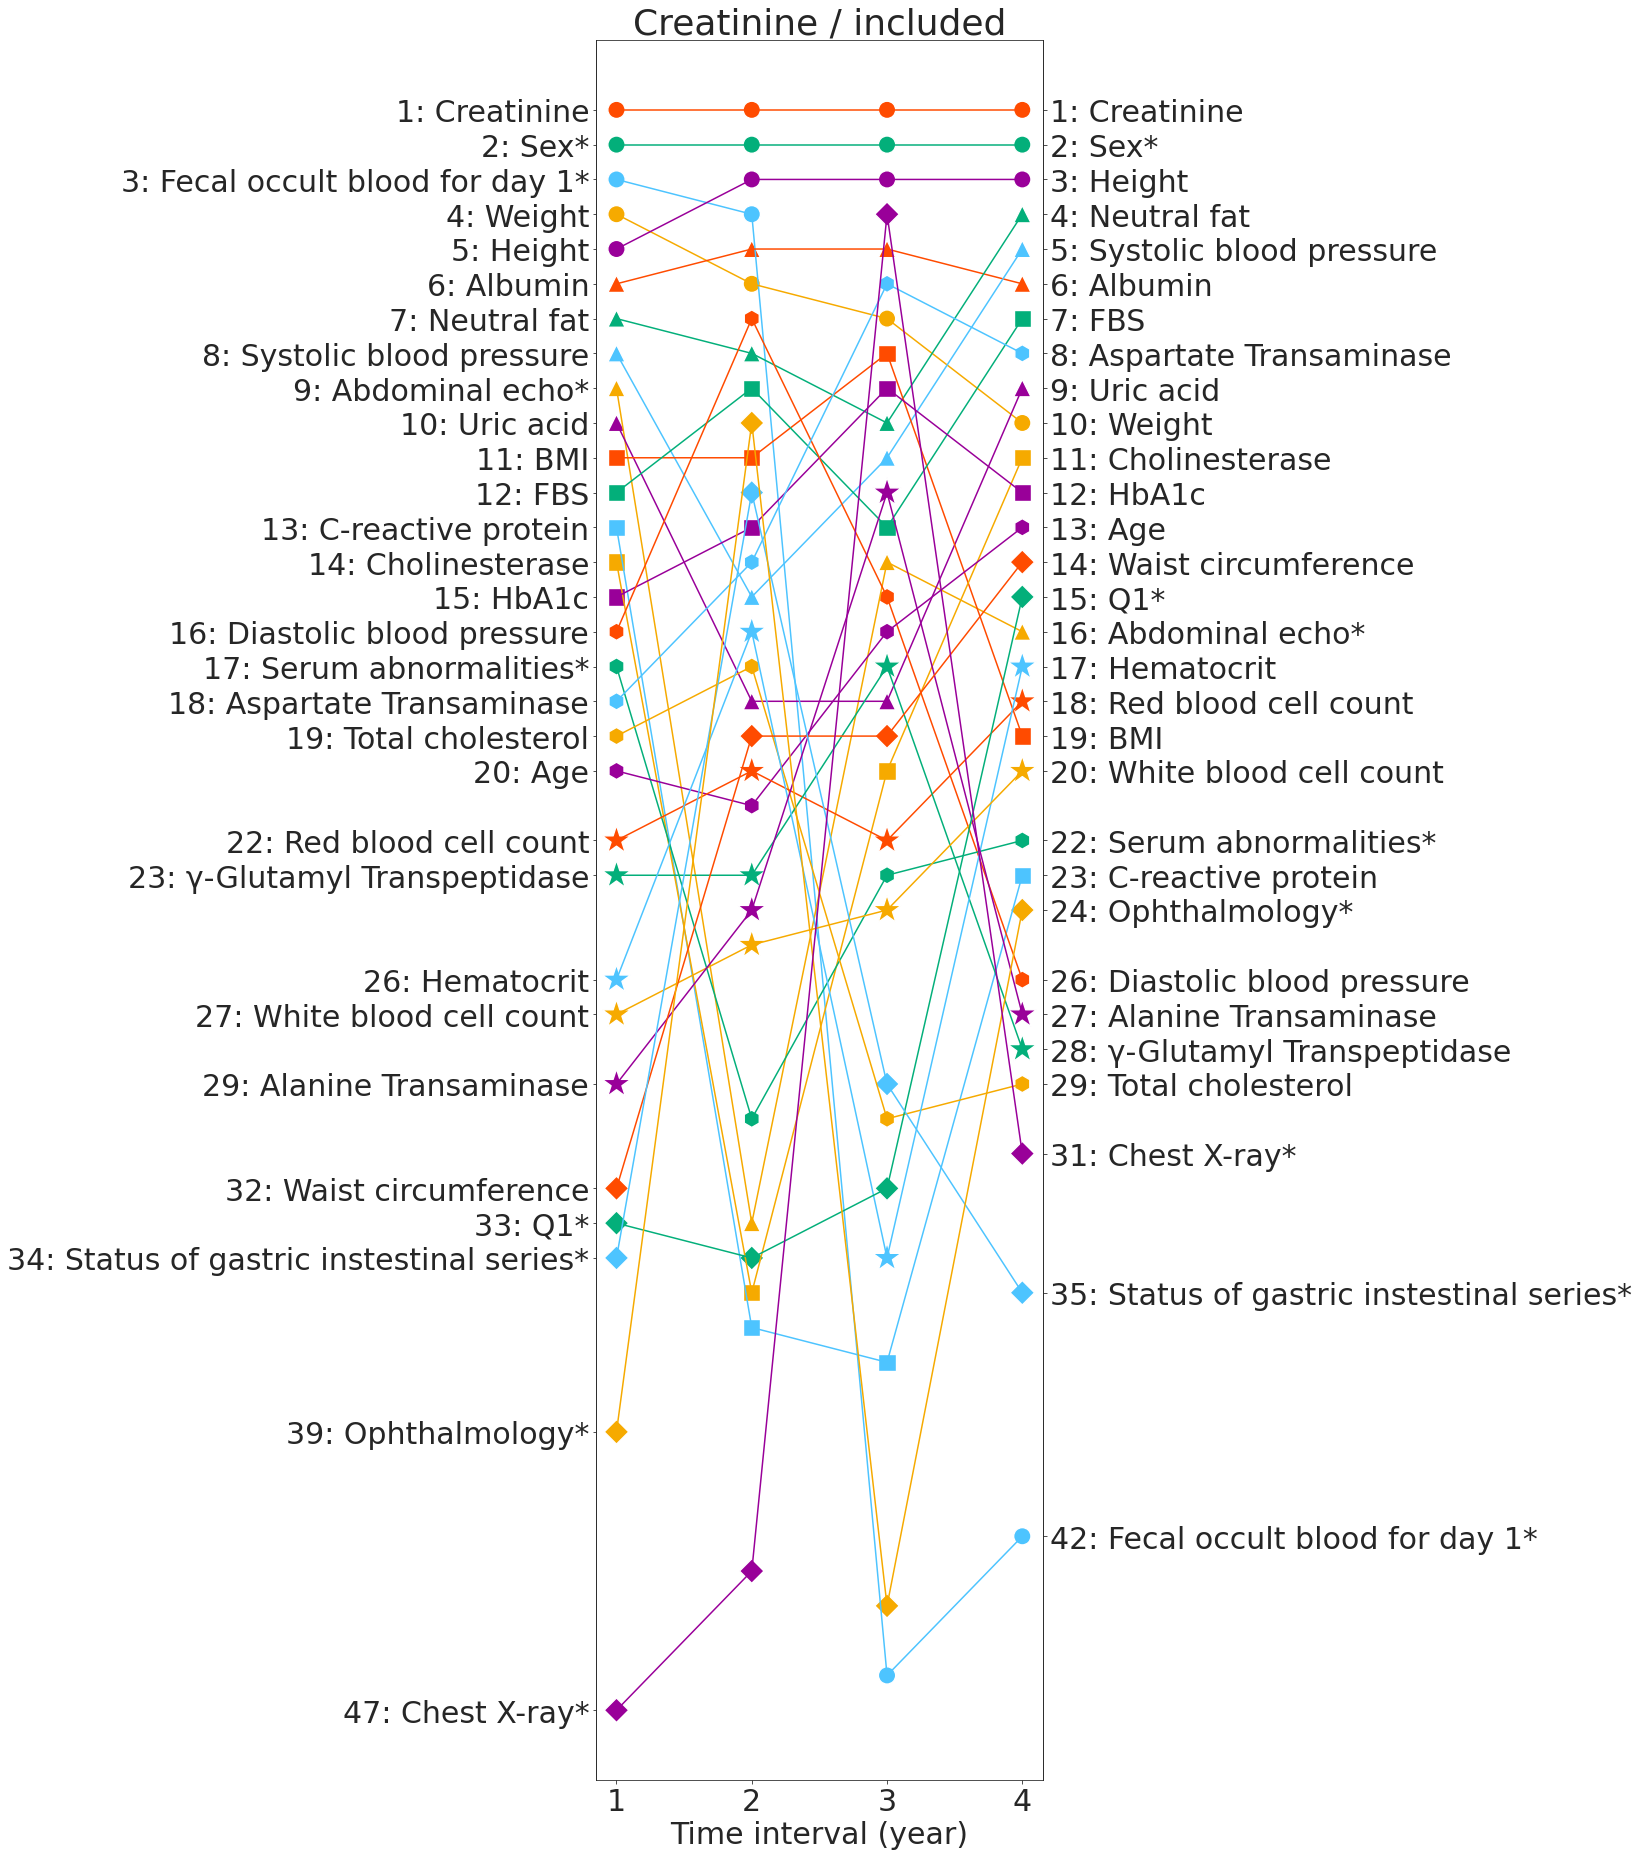

In [143]:
df_ranking = makeRankingInYearsDataFrame(config_dir_dict_creatinine["関連指標あり"], creatinine_dict)
drawRankingYearsChange(path_to_output_dict, list(config_dir_dict_creatinine["関連指標あり"].values())[0], df_ranking)

### Scatter plot

In [ ]:
df_years_creatinine_included = makeSHAPandTruePredValueDataFrame(condition="関連指標あり", config_dir_dict=config_dir_dict_creatinine, target_dict=creatinine_dict, is_merged=True)

In [ ]:
for column in df_years_creatinine_included["Attribute"].unique():
    makeScatterPlotSHAPValueAndInputValue(path_to_output_dict, list(config_dir_dict_creatinine["関連指標あり"].values())[0], df_years_creatinine_included, column)

## Not included

### Ranking

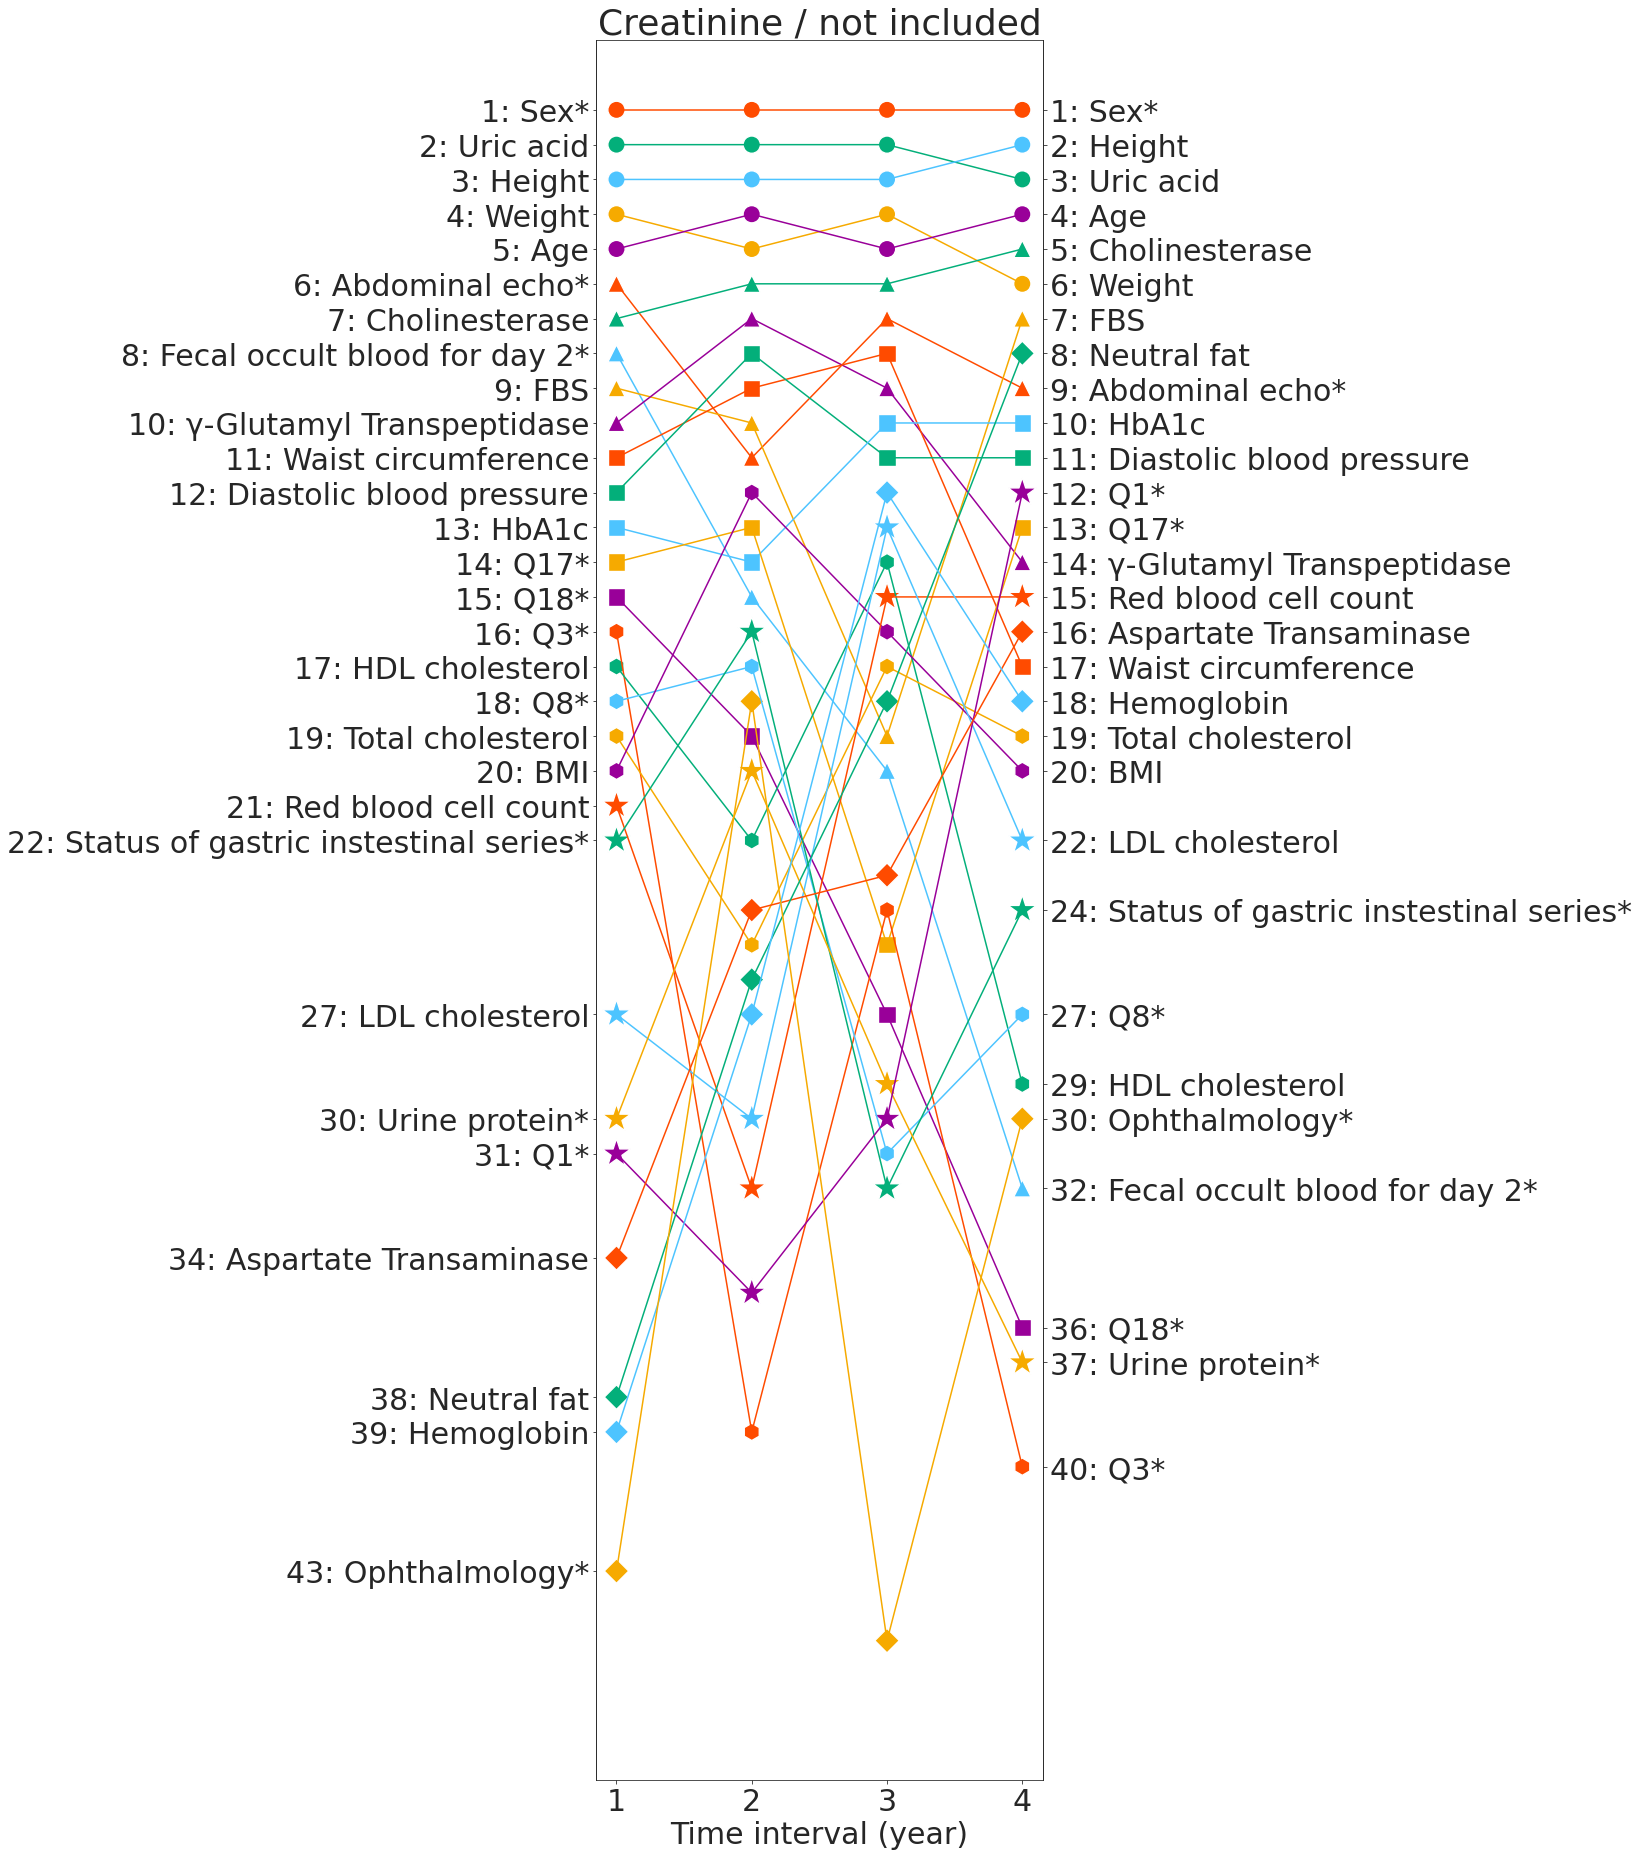

In [145]:
df_ranking = makeRankingInYearsDataFrame(config_dir_dict_creatinine["関連指標なし"], creatinine_dict)
drawRankingYearsChange(path_to_output_dict, list(config_dir_dict_creatinine["関連指標なし"].values())[0], df_ranking)

### Scatter plot

In [ ]:
df_years_creatinine_not_included = makeSHAPandTruePredValueDataFrame(condition="関連指標なし", config_dir_dict=config_dir_dict_creatinine, target_dict=creatinine_dict, is_merged=True)

In [ ]:
for column in df_years_creatinine_not_included["Attribute"].unique():
    makeScatterPlotSHAPValueAndInputValue(path_to_output_dict, list(config_dir_dict_creatinine["関連指標なし"].values())[0], df_years_creatinine_not_included, column)